## **Preparing data**

In [ ]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

def stopwords(link):
    response = requests.get(link)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        text = soup.get_text()

        words = re.findall(r'\b\w+\b', text)

        return words
    else:
        print("Error in fetching stopwords from URL:", response.status_code)
        return None

# Example URL
link = 'https://www.site.uottawa.ca/~diana/csi5180/StopWords'

# Extract words from the web page
recommended_stopwords = stopwords(link)

# Print the extracted words

if recommended_stopwords:
    print("Words extracted from the web page:", recommended_stopwords)

Words extracted from the web page: ['a', 'about', 'above', 'ac', 'according', 'accordingly', 'across', 'actually', 'ad', 'adj', 'af', 'after', 'afterwards', 'again', 'against', 'al', 'albeit', 'all', 'almost', 'alone', 'along', 'already', 'als', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'apart', 'apparently', 'are', 'aren', 'arise', 'around', 'as', 'aside', 'at', 'au', 'auf', 'aus', 'aux', 'av', 'avec', 'away', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'began', 'begin', 'beginning', 'begins', 'behind', 'bei', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'billion', 'both', 'briefly', 'but', 'by', 'c', 'came', 'can', 'cannot', 'canst', 'caption', 'captions', 'certain', 'certainly', 'cf', 'choose', 'chooses', 'choosing', 'chose', 'chosen', 'clear', 'clearly', 'co', 'come', 'comes', 'con', 'cont

In [ ]:
import nltk
import random
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

## Preprocess and tokenize text
def preprocess_and_tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokenizer = WordPunctTokenizer()

    tokens = tokenizer.tokenize(text)
    # cleaned_tokens = [stemmer.stem(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    cleaned_tokens = [re.sub('[^a-zA-Z]', ' ', token) for token in tokens if token.lower() not in recommended_stopwords and token.isalpha()]
    cleaned_tokens = [token.lower().strip() for token in cleaned_tokens if token.strip()]
    preprocessed_tokens = lemmatisation(cleaned_tokens)
    # preprocessed_tokens = stemming(preprocessed_tokens)
    preprocessed_text = ' '.join(cleaned_tokens)  # For the preprocessed column
    return preprocessed_text, cleaned_tokens
## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt

def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt


##Creating the samples
def create_samples(url_txt, label, n_samples=200, record_length=150):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_text = ' '.join(words[start_index:start_index + record_length])
        preprocessed_text, tokens = preprocess_and_tokenize(sample_text)

        samples.append({
            'Title': title,
            'Author': author,
            'Label': label,
            'Preprocessed_Text': preprocessed_text,
            'Tokens': tokens
        })

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/1342/pg1342-images.html",
             "https://www.gutenberg.org/cache/epub/2489/pg2489-images.html",
             "https://www.gutenberg.org/cache/epub/43/pg43-images.html",
             "https://www.gutenberg.org/cache/epub/174/pg174-images.html",
             "https://www.gutenberg.org/cache/epub/1661/pg1661-images.html",
             "https://www.gutenberg.org/cache/epub/36/pg36-images.html"]
df = create_dataframe(book_urls)



df


,Title,Author,Label,Preprocessed_Text,Tokens
0,Pride and Prejudice,Jane Austen,a,saying people lucky master sir know world meet...,"[saying, people, lucky, master, sir, know, wor..."
1,Pride and Prejudice,Jane Austen,a,div class figcenter style width role figure ar...,"[div, class, figcenter, style, width, role, fi..."
2,Pride and Prejudice,Jane Austen,a,result previous study austen readers pleasant ...,"[result, previous, study, austen, readers, ple..."
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged household ...,"[tongue, servants, waited, table, judged, hous..."
4,Pride and Prejudice,Jane Austen,a,relation patroness happened overhear gentleman...,"[relation, patroness, happened, overhear, gent..."
...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water..."
1196,The War of the Worlds,H. G. Wells,f,look artilleryman detailed clearing people hou...,"[look, artilleryman, detailed, clearing, peopl..."
1197,The War of the Worlds,H. G. Wells,f,striking brevity martians alarmed approach cro...,"[striking, brevity, martians, alarmed, approac..."
1198,The War of the Worlds,H. G. Wells,f,brutes god ugly brutes repeated man pit answer...,"[brutes, god, ugly, brutes, repeated, man, pit..."


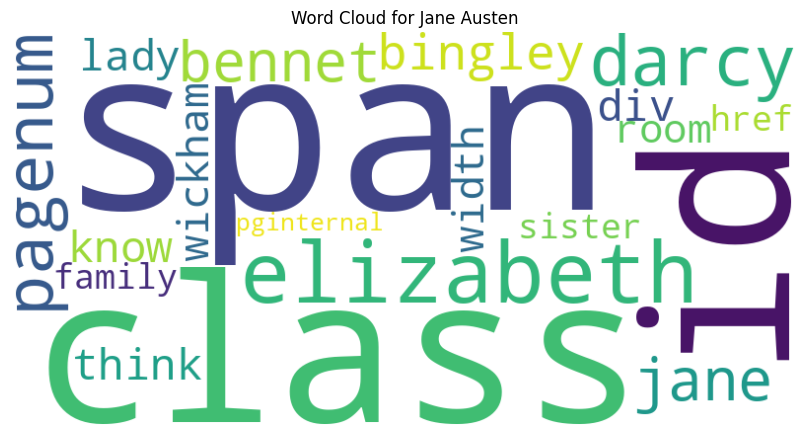

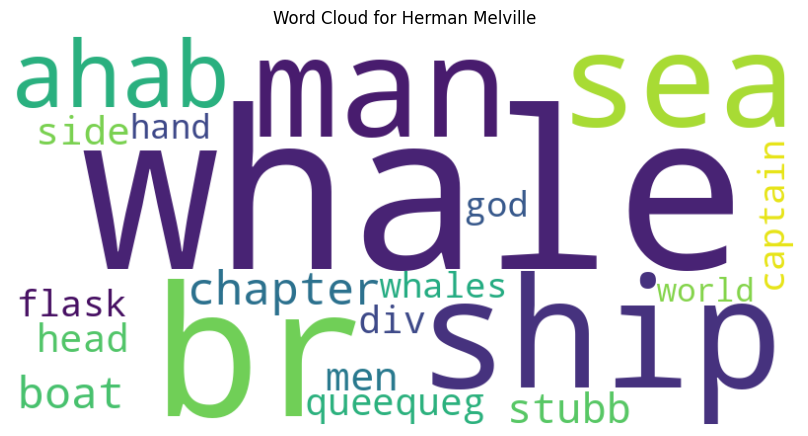

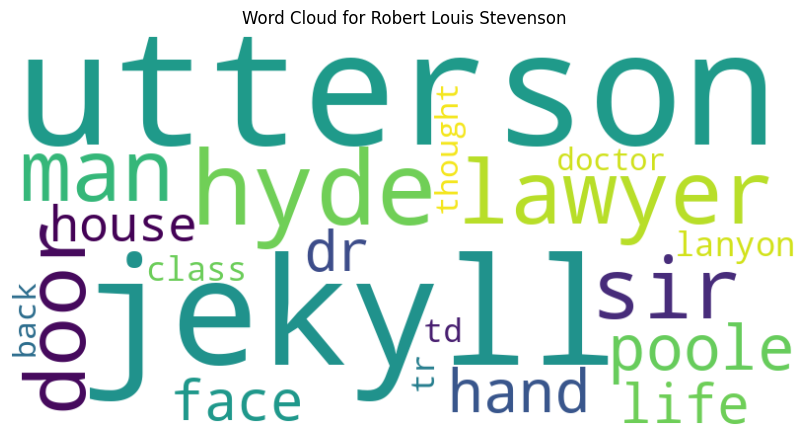

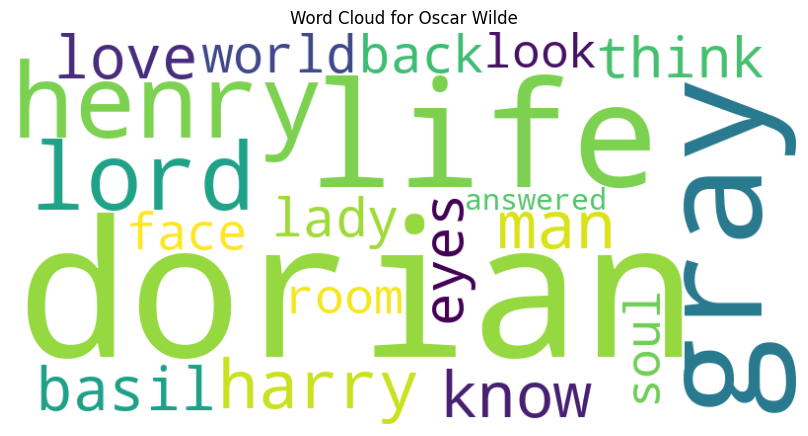

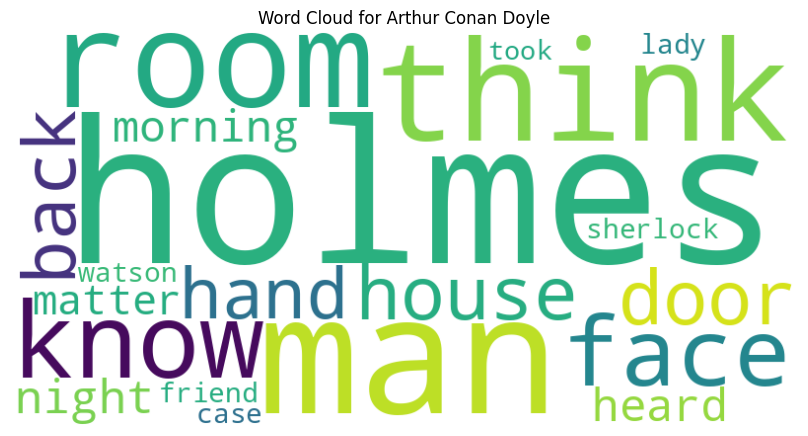

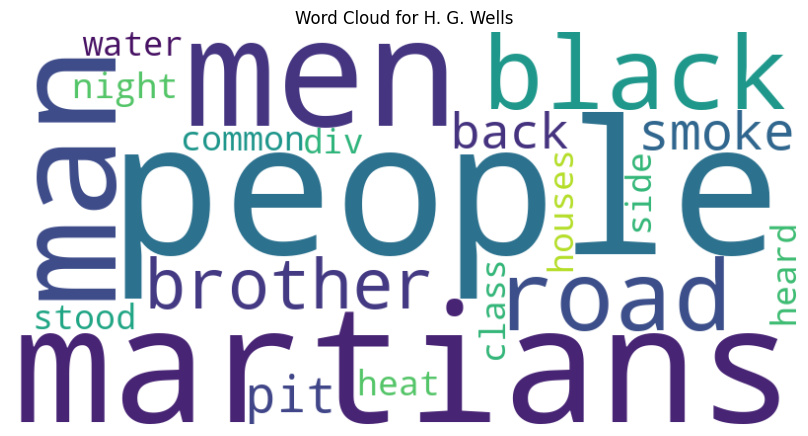

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'df' is your DataFrame and it includes 'Author', 'Title', and 'Tokens' columns

def generate_word_clouds(df, column):
    unique_books = df[column].unique()

    for book in unique_books:
        # Aggregate tokens for the book
        all_tokens = sum(df[df[column] == book]['Tokens'], [])

        # Count frequencies and select top 20 words
        top_words = dict(Counter(all_tokens).most_common(20))

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {book}')
        plt.axis('off')
        plt.tight_layout(pad=3)
        plt.show()

# Generate word clouds for each book by author or title
generate_word_clouds(df, 'Author')  # or 'Title' depending on your preference


In [ ]:
import pandas as pd

# Assuming `df` is your DataFrame created from `create_dataframe` function
# Example dictionary, replace 'Author A', 'Author B', etc., with actual author names and their genres
author_to_genre = {
    'Jane Austen': 'Classic Romance',
    'Herman Melville': 'Adventure/Sea Story',
    'Robert Louis Stevenson': 'Psychological Thriller/Mystery',
    'Oscar Wilde': 'Philosophical Fiction',
    'Arthur Conan Doyle': 'Mystery/Detective Fiction',
    'H. G. Wells': 'Science Fiction'

    # Add more mappings as needed
}

# Function to map each author to a genre
def map_genre(author):
    return author_to_genre.get(author, 'Unknown')  # Default genre if author not found

# Apply the function to create a new 'Genre' column based on 'Author' column
df['Genre'] = df['Author'].apply(map_genre)

df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre
0,Pride and Prejudice,Jane Austen,a,saying people lucky master sir know world meet...,"[saying, people, lucky, master, sir, know, wor...",Classic Romance
1,Pride and Prejudice,Jane Austen,a,div class figcenter style width role figure ar...,"[div, class, figcenter, style, width, role, fi...",Classic Romance
2,Pride and Prejudice,Jane Austen,a,result previous study austen readers pleasant ...,"[result, previous, study, austen, readers, ple...",Classic Romance
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged household ...,"[tongue, servants, waited, table, judged, hous...",Classic Romance
4,Pride and Prejudice,Jane Austen,a,relation patroness happened overhear gentleman...,"[relation, patroness, happened, overhear, gent...",Classic Romance
...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water...",Science Fiction
1196,The War of the Worlds,H. G. Wells,f,look artilleryman detailed clearing people hou...,"[look, artilleryman, detailed, clearing, peopl...",Science Fiction
1197,The War of the Worlds,H. G. Wells,f,striking brevity martians alarmed approach cro...,"[striking, brevity, martians, alarmed, approac...",Science Fiction
1198,The War of the Worlds,H. G. Wells,f,brutes god ugly brutes repeated man pit answer...,"[brutes, god, ugly, brutes, repeated, man, pit...",Science Fiction


In [ ]:
# Optimal Topics

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Assuming 'Tokens' is a list of tokenized documents
# Create a Gensim dictionary
dictionary = Dictionary(df['Tokens'])

# Filter out tokens that appear in less than 6 documents or more than 70% of the documents
dictionary.filter_extremes(no_below=6, no_above=0.7)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in df['Tokens']]

# # Hyperparameter tuning for number of topics
# coherence_scores = []
# for num_topics in range(2, 10):
#     lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, alpha='auto')
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=df['Tokens'], dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     coherence_scores.append((num_topics, coherence_lda))

# # Find the optimal number of topics based on coherence score
# optimal_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
# print("Optimal Number of Topics:", optimal_num_topics)

In [ ]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=10, alpha='auto')
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['Tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.40826632104873734


## LDA Modelling


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['Tokens'])


lda = LatentDirichletAllocation(n_components=6)  # Adjust number of topics as needed
X_lda = lda.fit_transform(X)
print('Size of the Dataframe', df.shape)
print('X_lda',X_lda.shape)
y = df['Author'].values



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Size of the Dataframe (1200, 6)
X_lda (1200, 6)


In [ ]:
df['X_lda'] = X_lda.tolist()
df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre,X_lda
0,Pride and Prejudice,Jane Austen,a,saying people lucky master sir know world meet...,"[saying, people, lucky, master, sir, know, wor...",Classic Romance,"[0.18796867695134564, 0.7988921496528615, 0.00..."
1,Pride and Prejudice,Jane Austen,a,div class figcenter style width role figure ar...,"[div, class, figcenter, style, width, role, fi...",Classic Romance,"[0.7999532685036382, 0.002267773970422109, 0.0..."
2,Pride and Prejudice,Jane Austen,a,result previous study austen readers pleasant ...,"[result, previous, study, austen, readers, ple...",Classic Romance,"[0.16577776251025753, 0.29660022903776356, 0.4..."
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged household ...,"[tongue, servants, waited, table, judged, hous...",Classic Romance,"[0.5977527386842076, 0.17925786240934002, 0.21..."
4,Pride and Prejudice,Jane Austen,a,relation patroness happened overhear gentleman...,"[relation, patroness, happened, overhear, gent...",Classic Romance,"[0.9829226598820512, 0.0034229827781058794, 0...."
...,...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water...",Science Fiction,"[0.4290107601034847, 0.002892862627529775, 0.0..."
1196,The War of the Worlds,H. G. Wells,f,look artilleryman detailed clearing people hou...,"[look, artilleryman, detailed, clearing, peopl...",Science Fiction,"[0.0034998416913562757, 0.003498796749707909, ..."
1197,The War of the Worlds,H. G. Wells,f,striking brevity martians alarmed approach cro...,"[striking, brevity, martians, alarmed, approac...",Science Fiction,"[0.002791753149946603, 0.002791407037615773, 0..."
1198,The War of the Worlds,H. G. Wells,f,brutes god ugly brutes repeated man pit answer...,"[brutes, god, ugly, brutes, repeated, man, pit...",Science Fiction,"[0.6288350598109491, 0.0035909225409880598, 0...."


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

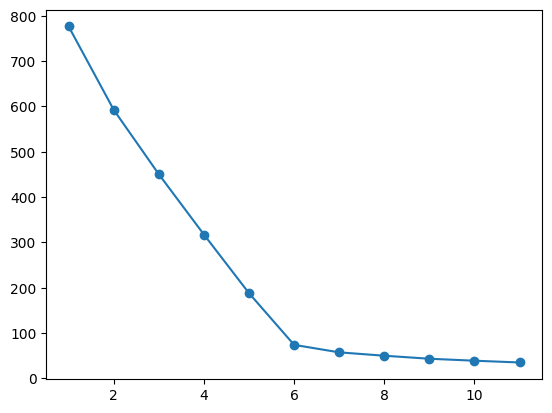

In [ ]:
from sklearn.cluster import KMeans
sse = []

for i in range(1,12):
    kmeans = KMeans(n_clusters = i,random_state = 50)
    kmeans.fit(X_lda)
    sse.append(kmeans.inertia_)

plt.plot(range(1,12),sse)
plt.scatter(range(1,12),sse)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
k_values = range(2,20)

silhouette_scores = []

for i in k_values:
  kmeans = KMeans(n_clusters=i, random_state=0)
  labels = kmeans.fit(X_lda)
  silhouette_avg = silhouette_score(X_lda, kmeans.labels_)
  print(f"silhouette score for k value {i} -> {silhouette_avg}")
  silhouette_scores.append(silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 2 -> 0.28723854317582675
silhouette score for k value 3 -> 0.40768947808709577
silhouette score for k value 4 -> 0.5272136381317256
silhouette score for k value 5 -> 0.634130940345064


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 6 -> 0.7402307494863567
silhouette score for k value 7 -> 0.7155635632263379


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 8 -> 0.7145554953203789
silhouette score for k value 9 -> 0.7268406256029979


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 10 -> 0.7283667198856217
silhouette score for k value 11 -> 0.7433667621175314


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 12 -> 0.7585032712891422
silhouette score for k value 13 -> 0.7531828096721224


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 14 -> 0.758123015847194
silhouette score for k value 15 -> 0.7631948147694042


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 16 -> 0.7671602715263742
silhouette score for k value 17 -> 0.7709156055270656


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 18 -> 0.7726928058497274


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette score for k value 19 -> 0.7701176903330135


In [ ]:
max(silhouette_scores)

0.7726928058497274

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 50)
clusters = kmeans.fit_predict(X_lda)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


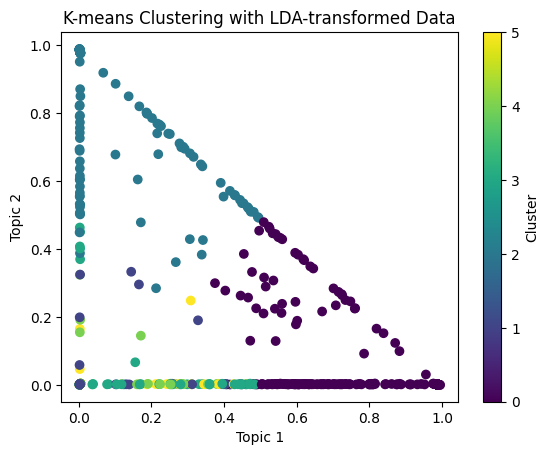

In [ ]:
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.title('K-means Clustering with LDA-transformed Data')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
df['k-means cluster'] = clusters
df.head(10)

,Title,Author,Label,Preprocessed_Text,Tokens,Genre,X_lda,k-means cluster
0,Pride and Prejudice,Jane Austen,a,saying people lucky master sir know world meet...,"[saying, people, lucky, master, sir, know, wor...",Classic Romance,"[0.18796867695134564, 0.7988921496528615, 0.00...",2
1,Pride and Prejudice,Jane Austen,a,div class figcenter style width role figure ar...,"[div, class, figcenter, style, width, role, fi...",Classic Romance,"[0.7999532685036382, 0.002267773970422109, 0.0...",0
2,Pride and Prejudice,Jane Austen,a,result previous study austen readers pleasant ...,"[result, previous, study, austen, readers, ple...",Classic Romance,"[0.16577776251025753, 0.29660022903776356, 0.4...",1
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged household ...,"[tongue, servants, waited, table, judged, hous...",Classic Romance,"[0.5977527386842076, 0.17925786240934002, 0.21...",0
4,Pride and Prejudice,Jane Austen,a,relation patroness happened overhear gentleman...,"[relation, patroness, happened, overhear, gent...",Classic Romance,"[0.9829226598820512, 0.0034229827781058794, 0....",0
5,Pride and Prejudice,Jane Austen,a,believe darcy unworthy bingley regard nature q...,"[believe, darcy, unworthy, bingley, regard, na...",Classic Romance,"[0.6211188705830538, 0.0033620954078828293, 0....",0
6,Pride and Prejudice,Jane Austen,a,compliance wait reason wickham play whist deli...,"[compliance, wait, reason, wickham, play, whis...",Classic Romance,"[0.4292379644620711, 0.5599476528050146, 0.002...",2
7,Pride and Prejudice,Jane Austen,a,supply subjects study country neighbourhood mo...,"[supply, subjects, study, country, neighbourho...",Classic Romance,"[0.6220907953169418, 0.0030006010689633015, 0....",0
8,Pride and Prejudice,Jane Austen,a,announce marriage bennet apartment repaired mi...,"[announce, marriage, bennet, apartment, repair...",Classic Romance,"[0.9841986556748112, 0.003164455676005257, 0.0...",0
9,Pride and Prejudice,Jane Austen,a,pretty woman bestow bingley fixed eyes face de...,"[pretty, woman, bestow, bingley, fixed, eyes, ...",Classic Romance,"[0.9858130548449312, 0.00284213512404041, 0.00...",0


In [ ]:
df['Genre'].unique()

array(['Classic Romance', 'Adventure/Sea Story',
       'Psychological Thriller/Mystery', 'Philosophical Fiction',
       'Mystery/Detective Fiction', 'Science Fiction'], dtype=object)

# Error Analysis

In [ ]:
from collections import Counter
token_list = []
for i in df[df['Genre'] == 'Adventure/Sea Story']['Tokens']:
  len(i)
  token_list.extend(i)
print(len(token_list))
word_counts = Counter(token_list)

# Get the top 10 most common words
top_10_words = word_counts.most_common(20)

# Print the top 10 most common words
print("Top 10 most frequent words:")
for word, count in top_10_words:
    print(word, ":", count)

12039
Top 10 most frequent words:
whale : 136
br : 86
ship : 73
man : 67
sea : 67
ahab : 57
chapter : 57
boat : 51
stubb : 45
men : 42
side : 39
head : 38
div : 36
queequeg : 36
flask : 34
captain : 34
god : 32
whales : 32
hand : 29
world : 28


In [ ]:
from collections import Counter
token_list = []
for i in df[df['Genre'] == 'Classic Romance']['Tokens']:
  len(i)
  token_list.extend(i)
print(len(token_list))
word_counts = Counter(token_list)

# Get the top 10 most common words
top_10_words = word_counts.most_common(20)

# Print the top 10 most common words
print("Top 10 most frequent words:")
for word, count in top_10_words:
    print(word, ":", count)

10733
Top 10 most frequent words:
span : 258
class : 201
id : 198
elizabeth : 140
darcy : 117
pagenum : 110
jane : 82
bennet : 76
bingley : 61
know : 47
div : 46
think : 46
width : 44
lady : 44
wickham : 43
room : 39
family : 39
sister : 38
href : 37
pginternal : 37


In [ ]:
from collections import Counter
token_list = []
for i in df[df['Genre'] == 'Philosophical Fiction']['Tokens']:
  len(i)
  token_list.extend(i)
print(len(token_list))
word_counts = Counter(token_list)

# Get the top 10 most common words
top_10_words = word_counts.most_common(20)

# Print the top 10 most common words
print("Top 10 most frequent words:")
for word, count in top_10_words:
    print(word, ":", count)

10389
Top 10 most frequent words:
dorian : 162
life : 89
gray : 84
henry : 82
lord : 77
harry : 65
man : 64
know : 59
basil : 54
love : 54
think : 47
eyes : 46
lady : 42
back : 41
world : 39
face : 38
room : 37
soul : 37
look : 37
answered : 35


In [ ]:
from collections import Counter
token_list = []
for i in df[df['Genre'] == 'Psychological Thriller/Mystery']['Tokens']:
  len(i)
  token_list.extend(i)
print(len(token_list))
word_counts = Counter(token_list)

# Get the top 10 most common words
top_10_words = word_counts.most_common(20)

# Print the top 10 most common words
print("Top 10 most frequent words:")
for word, count in top_10_words:
    print(word, ":", count)

10402
Top 10 most frequent words:
utterson : 142
jekyll : 126
hyde : 105
lawyer : 77
man : 72
sir : 71
door : 68
poole : 65
hand : 58
dr : 53
face : 51
life : 50
house : 49
lanyon : 47
class : 46
td : 44
tr : 44
thought : 42
back : 42
doctor : 40


In [ ]:
from collections import Counter
token_list = []
for i in df[df['Genre'] == 'Science Fiction']['Tokens']:
  len(i)
  token_list.extend(i)
print(len(token_list))
word_counts = Counter(token_list)

# Get the top 10 most common words
top_10_words = word_counts.most_common(20)

# Print the top 10 most common words
print("Top 10 most frequent words:")
for word, count in top_10_words:
    print(word, ":", count)

11616
Top 10 most frequent words:
people : 78
martians : 74
men : 64
man : 57
black : 57
road : 54
brother : 46
smoke : 46
pit : 42
back : 41
night : 40
stood : 37
class : 37
common : 36
heard : 36
heat : 35
houses : 35
side : 35
water : 34
div : 34


In [ ]:

from collections import Counter
token_list = []
for i in df[df['Genre'] == 'Mystery/Detective Fiction']['Tokens']:
  len(i)
  token_list.extend(i)
print(len(token_list))
word_counts = Counter(token_list)

# Get the top 10 most common words
top_10_words = word_counts.most_common(20)

# Print the top 10 most common words
print("Top 10 most frequent words:")
for word, count in top_10_words:
    print(word, ":", count)

9382
Top 10 most frequent words:
holmes : 129
man : 88
think : 59
room : 56
know : 48
face : 40
door : 37
house : 36
back : 35
hand : 33
night : 32
heard : 31
morning : 30
matter : 30
sherlock : 29
case : 29
lady : 28
friend : 27
watson : 27
took : 26


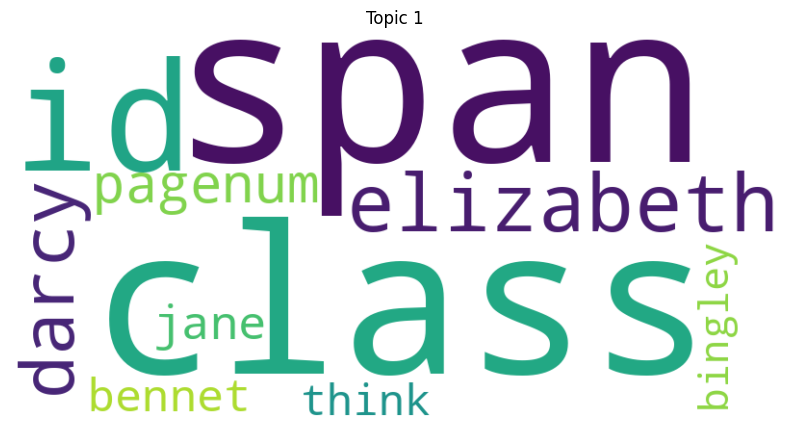

Topic 1:
span: 0.0274
class: 0.0234
id: 0.0216
elizabeth: 0.0146
darcy: 0.0122
pagenum: 0.0115
jane: 0.0086
bennet: 0.0079
think: 0.0072
bingley: 0.0064




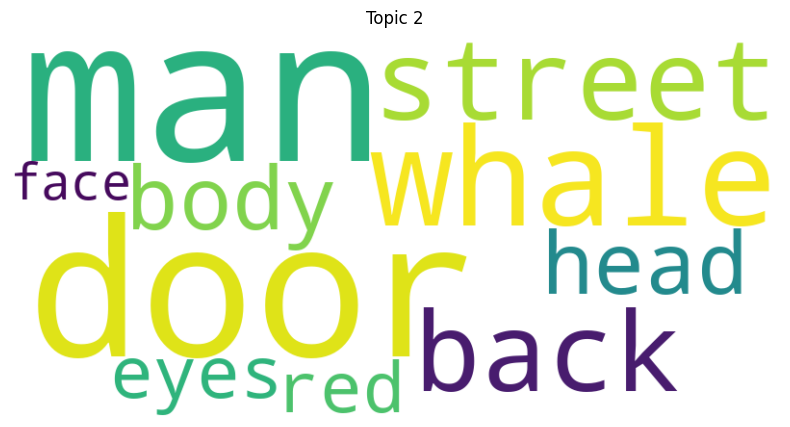

Topic 2:
man: 0.0093
door: 0.0083
whale: 0.0067
street: 0.0064
back: 0.0062
body: 0.0059
head: 0.0056
eyes: 0.0055
red: 0.0053
face: 0.0052




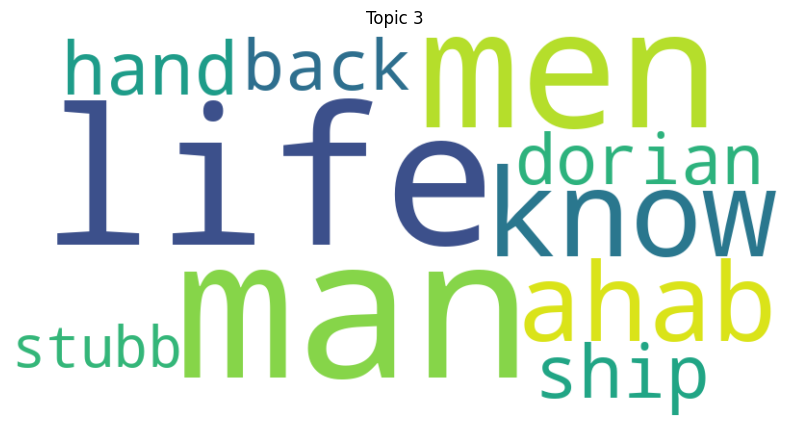

Topic 3:
man: 0.0111
life: 0.0103
men: 0.0077
know: 0.0070
ahab: 0.0059
ship: 0.0056
hand: 0.0056
back: 0.0051
dorian: 0.0050
stubb: 0.0049




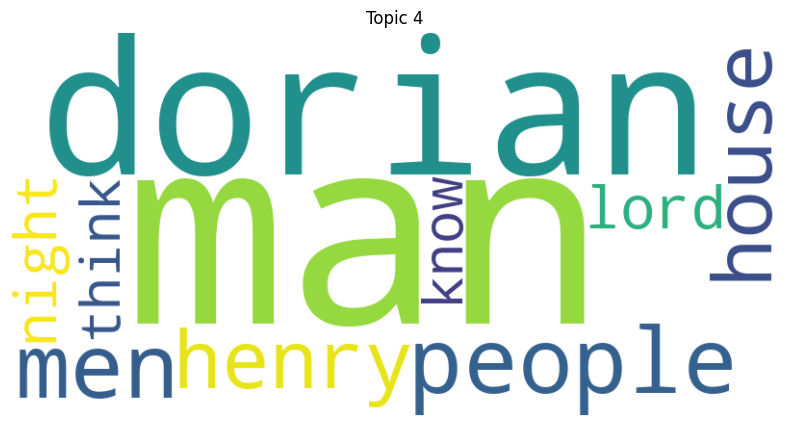

Topic 4:
man: 0.0100
dorian: 0.0092
people: 0.0080
men: 0.0078
house: 0.0061
henry: 0.0060
lord: 0.0060
night: 0.0057
think: 0.0052
know: 0.0051




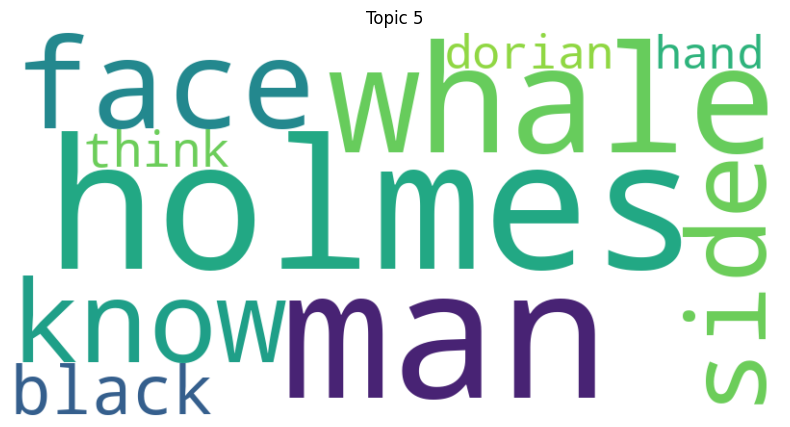

Topic 5:
man: 0.0084
holmes: 0.0084
whale: 0.0080
face: 0.0066
know: 0.0062
side: 0.0056
black: 0.0051
think: 0.0050
dorian: 0.0047
hand: 0.0044




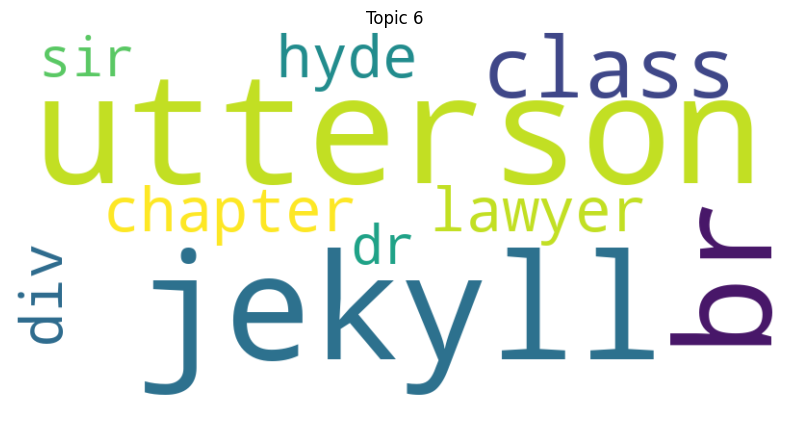

Topic 6:
utterson: 0.0197
jekyll: 0.0185
br: 0.0149
class: 0.0133
chapter: 0.0121
lawyer: 0.0120
hyde: 0.0113
div: 0.0110
dr: 0.0095
sir: 0.0094




In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'lda_model' is the trained LDA model
# Assuming 'dictionary' is the Gensim dictionary object
# Assuming 'num_topics' is the optimal number of topics determined previously

# Visualize topics and most common words
for topic_id in range(6):
    # Get the top words for the current topic
    top_words = lda_model.show_topic(topic_id, topn=10)  # Get the top 10 words for the topic

    # Create a dictionary of word probabilities for generating the word cloud
    wordcloud_dict = {word: prob for word, prob in top_words}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_id + 1}")
    plt.axis('off')
    plt.show()

    # Display the most common words for the topic
    print(f"Topic {topic_id + 1}:")
    for word, prob in top_words:
        print(f"{word}: {prob:.4f}")
    print("\n")

In [ ]:
frequency_table = df.groupby(['k-means cluster', 'Genre']).size().unstack(fill_value=0)

frequency_table

Genre,Adventure/Sea Story,Classic Romance,Mystery/Detective Fiction,Philosophical Fiction,Psychological Thriller/Mystery,Science Fiction
k-means cluster,,,,,,
0,35,141,39,77,20,35
1,32,1,20,21,46,53
2,35,42,45,29,29,20
3,28,5,30,26,52,60
4,33,4,46,9,16,18
5,37,7,20,38,37,14


In [ ]:
df.columns

Index(['Title', 'Author', 'Label', 'Preprocessed_Text', 'Tokens', 'Genre',
       'X_lda', 'k-means cluster'],
      dtype='object')

In [ ]:
df['true_label'] = None

In [ ]:
df.loc[df['Genre'] == 'Adventure/Sea Story', 'true_label'] = 2
df.loc[df['Genre'] == 'Classic Romance', 'true_label'] = 0
df.loc[df['Genre'] == 'Mystery/Detective Fiction', 'true_label'] = 4
df.loc[df['Genre'] == 'Philosophical Fiction', 'true_label'] = 5
df.loc[df['Genre'] == 'Psychological Thriller/Mystery', 'true_label'] = 1
df.loc[df['Genre'] == 'Science Fiction', 'true_label'] = 3

In [ ]:
frequency_table2 = df.groupby(['k-means cluster', 'true_label']).size().unstack(fill_value=0)

frequency_table2

true_label,0.0,1.0,2.0,3.0,4.0,5.0
k-means cluster,,,,,,
0,141,20,35,35,39,77
1,1,46,32,53,20,21
2,42,29,35,20,45,29
3,5,52,28,60,30,26
4,4,16,33,18,46,9
5,7,37,37,14,20,38


In [ ]:
df.head(10)

,Title,Author,Label,Preprocessed_Text,Tokens,Genre,X_lda,k-means cluster,true_label
0,Pride and Prejudice,Jane Austen,a,saying people lucky master sir know world meet...,"[saying, people, lucky, master, sir, know, wor...",Classic Romance,"[0.5885086908298981, 0.003285769243389921, 0.0...",0,4
1,Pride and Prejudice,Jane Austen,a,div class figcenter style width role figure ar...,"[div, class, figcenter, style, width, role, fi...",Classic Romance,"[0.6097554778200981, 0.0022589835887521217, 0....",0,4
2,Pride and Prejudice,Jane Austen,a,result previous study austen readers pleasant ...,"[result, previous, study, austen, readers, ple...",Classic Romance,"[0.2181804992429688, 0.0031545783910578206, 0....",4,4
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged household ...,"[tongue, servants, waited, table, judged, hous...",Classic Romance,"[0.9842024071079513, 0.0031584586238583546, 0....",0,4
4,Pride and Prejudice,Jane Austen,a,relation patroness happened overhear gentleman...,"[relation, patroness, happened, overhear, gent...",Classic Romance,"[0.9829313657266252, 0.0034141506883379772, 0....",0,4
5,Pride and Prejudice,Jane Austen,a,believe darcy unworthy bingley regard nature q...,"[believe, darcy, unworthy, bingley, regard, na...",Classic Romance,"[0.7139768610234701, 0.0033576266789705337, 0....",0,4
6,Pride and Prejudice,Jane Austen,a,compliance wait reason wickham play whist deli...,"[compliance, wait, reason, wickham, play, whis...",Classic Romance,"[0.986495542894124, 0.0027039782552058197, 0.0...",0,4
7,Pride and Prejudice,Jane Austen,a,supply subjects study country neighbourhood mo...,"[supply, subjects, study, country, neighbourho...",Classic Romance,"[0.7060668922600998, 0.0030145235900718654, 0....",0,4
8,Pride and Prejudice,Jane Austen,a,announce marriage bennet apartment repaired mi...,"[announce, marriage, bennet, apartment, repair...",Classic Romance,"[0.9842156815679122, 0.0031554215238004616, 0....",0,4
9,Pride and Prejudice,Jane Austen,a,pretty woman bestow bingley fixed eyes face de...,"[pretty, woman, bestow, bingley, fixed, eyes, ...",Classic Romance,"[0.6107369418743924, 0.0028444242005597085, 0....",0,4


In [ ]:
df.columns

Index(['Title', 'Author', 'Label', 'Preprocessed_Text', 'Tokens', 'Genre',
       'X_lda'],
      dtype='object')

In [ ]:
df.isna().any()

Title                False
Author               False
Label                False
Preprocessed_Text    False
Tokens               False
Genre                False
X_lda                False
k-means cluster      False
true_label           False
dtype: bool

In [ ]:
df['k-means cluster'].unique()

array([0, 4, 2, 1, 5, 3], dtype=int32)

In [ ]:
df['true_label'].unique()

array([4, 1, 3, 5, 0, 2], dtype=object)

In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

def calculate_kappa(true_labels_encoded, cluster_labels):
    """
    Calculates Cohen's Kappa Score comparing true labels and clustering labels.

    Parameters:
    - true_labels_encoded: Encoded true labels (e.g., obtained using LabelEncoder).
    - cluster_labels: Cluster labels obtained from clustering algorithms.

    Returns:
    - kappa_score: Cohen's Kappa Score.
    """
    kappa_score = cohen_kappa_score(true_labels_encoded, cluster_labels)
    return kappa_score

# Corrected Kappa Scores calculation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

# label_encoder = LabelEncoder()
# true_labels_encoded = label_encoder.fit_transform(df['true_label'])

# Encode predicted labels if they are categorical
# predicted_labels_encoded = label_encoder.transform(df['k-means cluster'])
predicted_labels_encoded = df['k-means cluster']

kappa_kmeans = calculate_kappa(true_labels_encoded, predicted_labels_encoded)
print(f"Cohen's Kappa Score (K-means): {kappa_kmeans}")

# # Ensure the DataFrame contains the GMM labels
# df['GMM_Clusters'] = gmm_labels  # Add this line if it's missing
# kappa_gmm = calculate_kappa(true_labels_encoded, df['GMM_Clusters'])
# print(f"Cohen's Kappa Score (GMM): {kappa_gmm}")

# # Add hierarchical clustering labels to the DataFrame
# df['Hierarchical_Clusters'] = hierarchical_labels
# kappa_hierarchical = calculate_kappa(true_labels_encoded, df['Hierarchical_Clusters'])
# print(f"Cohen's Kappa Score (Hierarchical): {kappa_hierarchical}")

Cohen's Kappa Score (K-means): -0.02200000000000002


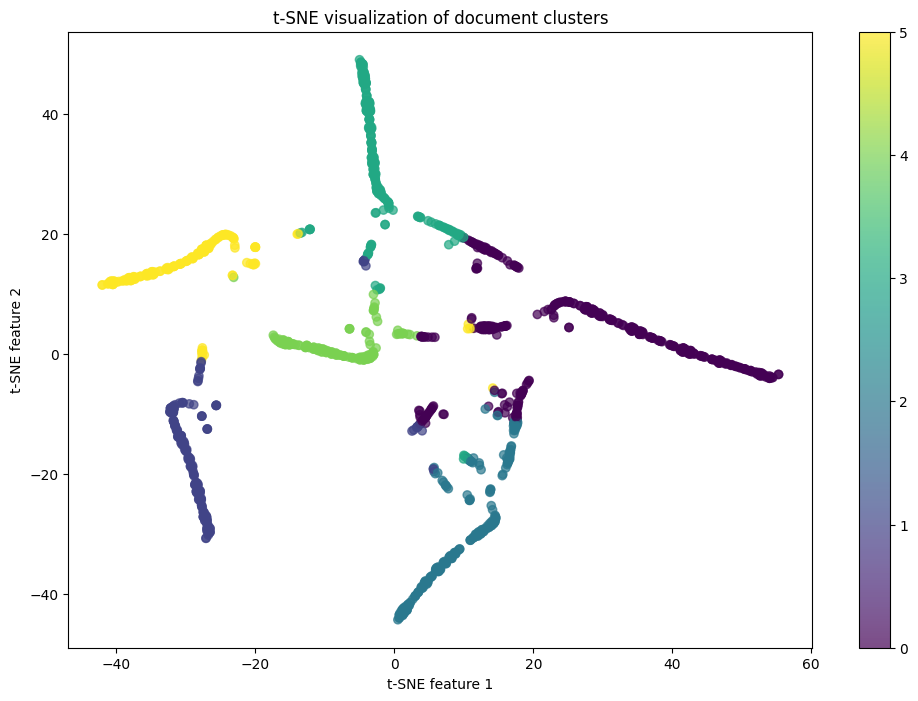

In [ ]:
from sklearn.manifold import TSNE

# Configure t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)

# Apply t-SNE to document vectors (this may take some time depending on the dataset size)
X_tsne = tsne.fit_transform(X_lda)
import matplotlib.pyplot as plt

# Assume 'kmeans_labels' are the cluster labels from the K-means clustering step
# Plot t-SNE 2D projection with cluster labels
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.7)

# Optionally add cluster centroids if it's meaningful in the t-SNE space (usually not for t-SNE)
# centroids = kmeans.cluster_centers_
# centroids_tsne = tsne.fit_transform(centroids)
# plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], c='red', marker='x')

plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of document clusters')
plt.show()


In [ ]:
X_lda

array([[0.58850869, 0.00328577, 0.00328469, 0.00328931, 0.00329204,
        0.3983395 ],
       [0.60975548, 0.00225898, 0.00226216, 0.00226424, 0.38119667,
        0.00226246],
       [0.2181805 , 0.00315458, 0.00315867, 0.76919209, 0.0031536 ,
        0.00316056],
       ...,
       [0.00282176, 0.00279353, 0.98588341, 0.0028216 , 0.00288259,
        0.0027971 ],
       [0.0035735 , 0.98208938, 0.00359269, 0.00358104, 0.00358315,
        0.00358024],
       [0.98688602, 0.00261722, 0.00263762, 0.00262209, 0.00261768,
        0.00261937]])

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6, random_state=0)
gmm.fit(X_lda)

GaussianMixture(n_components=6, random_state=0)

In [ ]:
gmm_silhouette_score = silhouette_score(X_lda, gmm.predict(X_lda))
gmm_silhouette_score

0.3720055588163592

In [ ]:
gmm_clusters = gmm.fit_predict(X_lda)
gmm_clusters.shape

(1200,)

In [ ]:
df['gmm_clusters'] = gmm_clusters
df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre,X_lda,k-means cluster,gmm_clusters
0,Pride and Prejudice,Jane Austen,a,saying people lucky master sir know world meet...,"[saying, people, lucky, master, sir, know, wor...",Classic Romance,"[0.18796867695134564, 0.7988921496528615, 0.00...",2,1
1,Pride and Prejudice,Jane Austen,a,div class figcenter style width role figure ar...,"[div, class, figcenter, style, width, role, fi...",Classic Romance,"[0.7999532685036382, 0.002267773970422109, 0.0...",0,3
2,Pride and Prejudice,Jane Austen,a,result previous study austen readers pleasant ...,"[result, previous, study, austen, readers, ple...",Classic Romance,"[0.16577776251025753, 0.29660022903776356, 0.4...",1,0
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged household ...,"[tongue, servants, waited, table, judged, hous...",Classic Romance,"[0.5977527386842076, 0.17925786240934002, 0.21...",0,0
4,Pride and Prejudice,Jane Austen,a,relation patroness happened overhear gentleman...,"[relation, patroness, happened, overhear, gent...",Classic Romance,"[0.9829226598820512, 0.0034229827781058794, 0....",0,4
...,...,...,...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water...",Science Fiction,"[0.4290107601034847, 0.002892862627529775, 0.0...",3,4
1196,The War of the Worlds,H. G. Wells,f,look artilleryman detailed clearing people hou...,"[look, artilleryman, detailed, clearing, peopl...",Science Fiction,"[0.0034998416913562757, 0.003498796749707909, ...",1,2
1197,The War of the Worlds,H. G. Wells,f,striking brevity martians alarmed approach cro...,"[striking, brevity, martians, alarmed, approac...",Science Fiction,"[0.002791753149946603, 0.002791407037615773, 0...",1,2
1198,The War of the Worlds,H. G. Wells,f,brutes god ugly brutes repeated man pit answer...,"[brutes, god, ugly, brutes, repeated, man, pit...",Science Fiction,"[0.6288350598109491, 0.0035909225409880598, 0....",0,4


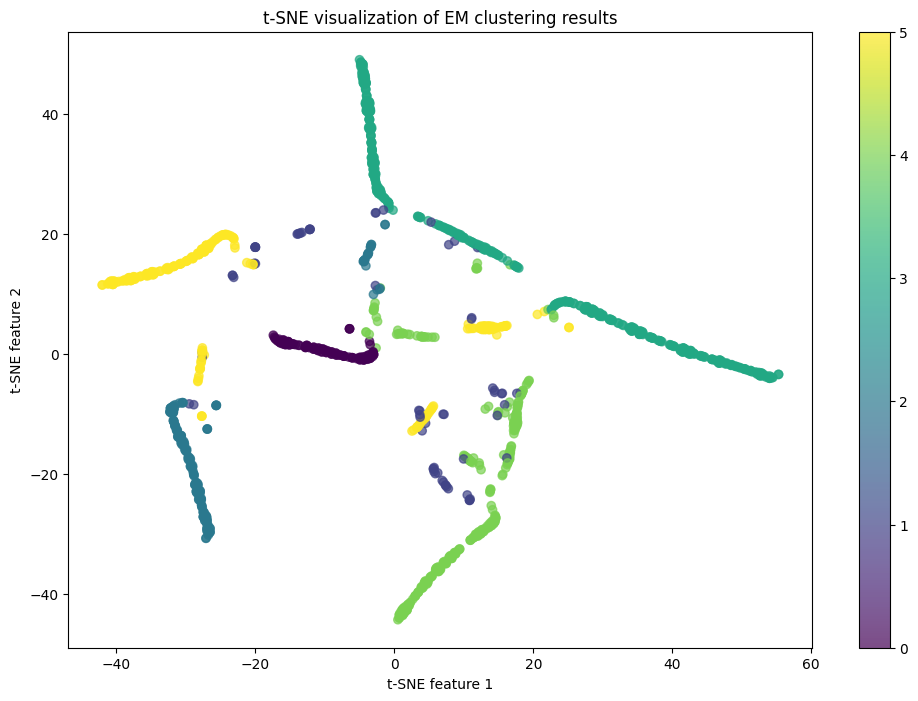

In [ ]:
from sklearn.mixture import GaussianMixture

# Optimal number of clusters from the silhouette analysis
optimal_clusters = 6

# Initialize and fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_lda)
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', marker='o', alpha=0.7)
plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of EM clustering results')
plt.show()


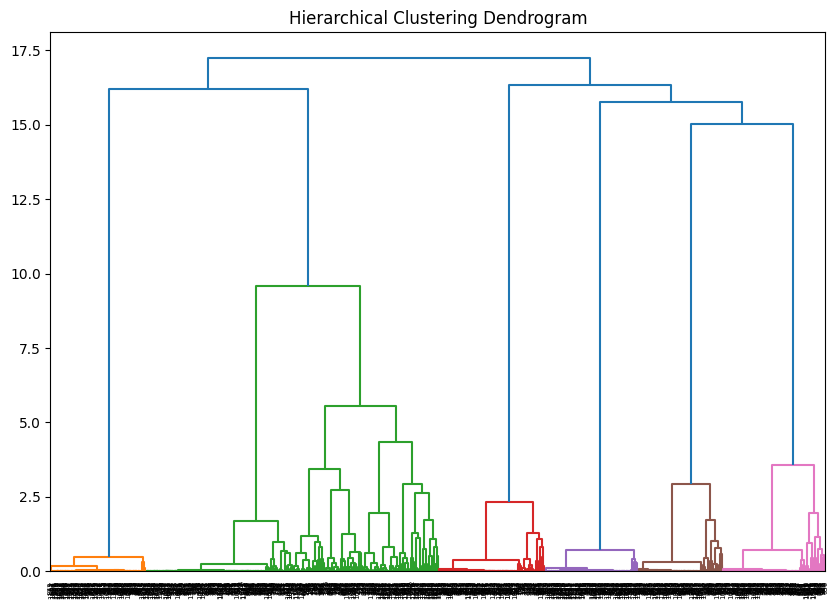

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
linkage_matrix = linkage(X_lda, method='ward')
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(linkage_matrix)
plt.show()

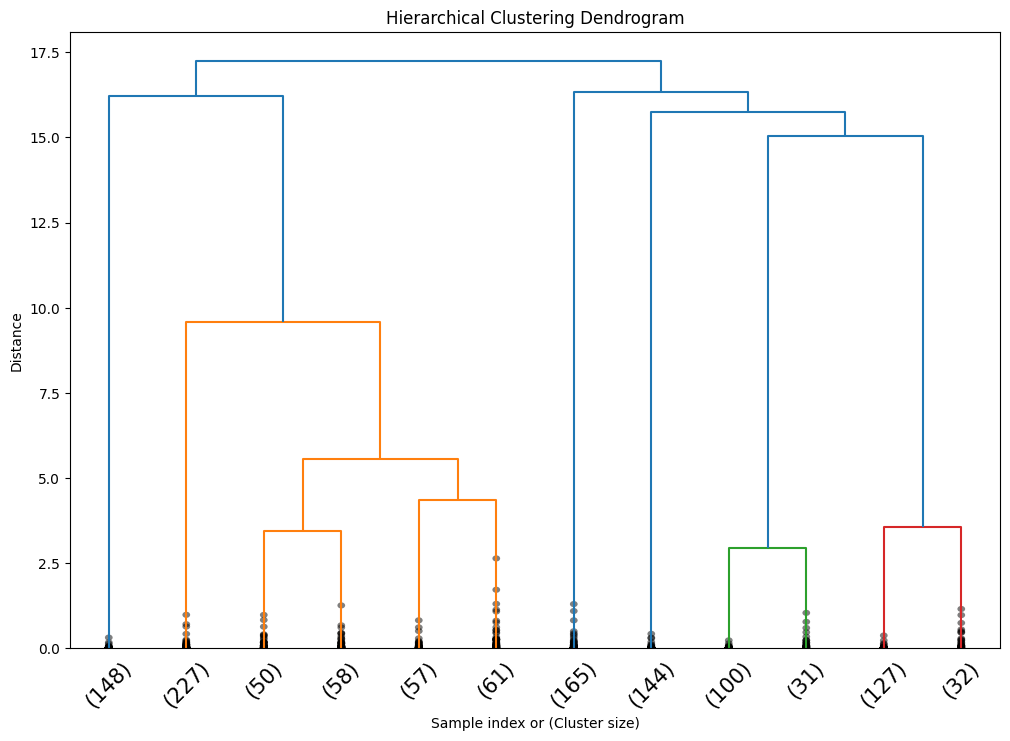

In [ ]:
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()

In [ ]:
df.columns

Index(['Title', 'Author', 'Label', 'Preprocessed_Text', 'Tokens', 'Genre',
       'X_lda', 'k-means cluster', 'gmm_clusters'],
      dtype='object')

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Assuming we're using the same number of clusters as the optimal number from silhouette analysis
hierarchical_labels = fcluster(linkage_matrix, t=6, criterion='maxclust')

In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

def calculate_kappa(true_labels_encoded, cluster_labels):
    """
    Calculates Cohen's Kappa Score comparing true labels and clustering labels.

    Parameters:
    - true_labels_encoded: Encoded true labels (e.g., obtained using LabelEncoder).
    - cluster_labels: Cluster labels obtained from clustering algorithms.

    Returns:
    - kappa_score: Cohen's Kappa Score.
    """
    kappa_score = cohen_kappa_score(true_labels_encoded, cluster_labels)
    return kappa_score

# Corrected Kappa Scores calculation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

kappa_kmeans = calculate_kappa(true_labels_encoded, df['k-means cluster'])
print(f"Cohen's Kappa Score (K-means): {kappa_kmeans}")

# Ensure the DataFrame contains the GMM labels
# df['GMM_Clusters'] = gmm_labels  # Add this line if it's missing
kappa_gmm = calculate_kappa(true_labels_encoded, df['gmm_clusters'])
print(f"Cohen's Kappa Score (GMM): {kappa_gmm}")

# Add hierarchical clustering labels to the DataFrame
df['Hierarchical_Clusters'] = hierarchical_labels
kappa_hierarchical = calculate_kappa(true_labels_encoded, df['Hierarchical_Clusters'])
print(f"Cohen's Kappa Score (Hierarchical): {kappa_hierarchical}")


Cohen's Kappa Score (K-means): -0.02200000000000002
Cohen's Kappa Score (GMM): -0.016999999999999904
Cohen's Kappa Score (Hierarchical): -0.03555772040915728


In [ ]:
# Calculate Silhouette Score for Hierarchical Clustering
silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
print(f"Silhouette Score (Hierarchical): {silhouette_hierarchical}")

Silhouette Score (Hierarchical): -0.014913368338798264


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


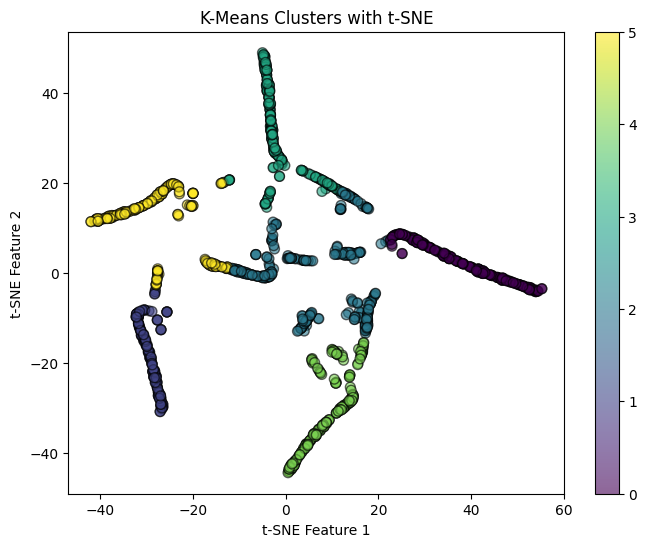

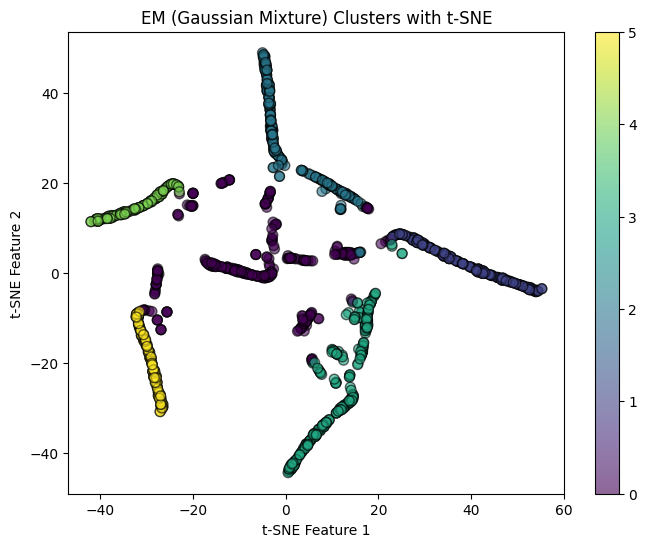

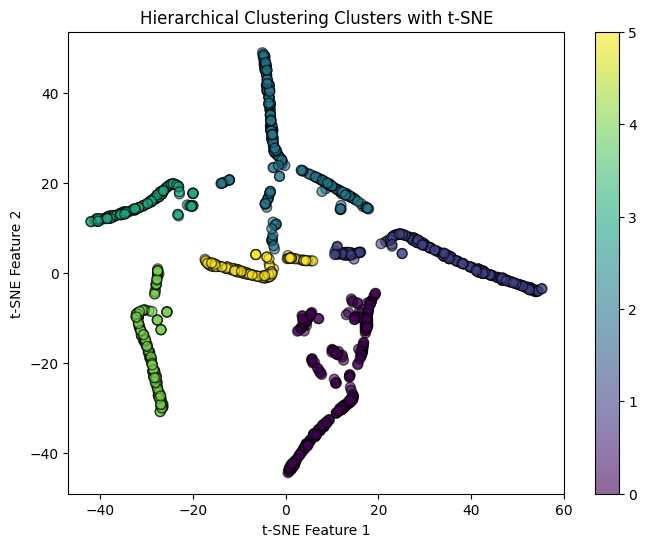

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())  # Assuming X is your TF-IDF matrix

# Define the clustering models
models = {
    "K-Means": KMeans(n_clusters=6, random_state=42),
    "EM (Gaussian Mixture)": GaussianMixture(n_components=6, random_state=42),
    "Hierarchical Clustering": AgglomerativeClustering(n_clusters=6)
}

# Plotting function for clusters
def plot_clusters_tsne(X, labels, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.title(f'{model_name} Clusters with t-SNE')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.colorbar()
    plt.show()

# Apply clustering and plot with t-SNE reduced data
for name, model in models.items():
    if name == "EM (Gaussian Mixture)":
        # Gaussian Mixture Model uses 'predict' to assign cluster labels
        model.fit(X_tsne)
        labels = model.predict(X_tsne)
    else:
        # KMeans and Hierarchical use 'fit_predict' to assign cluster labels
        labels = model.fit_predict(X_tsne)

    plot_clusters_tsne(X_tsne, labels, name)


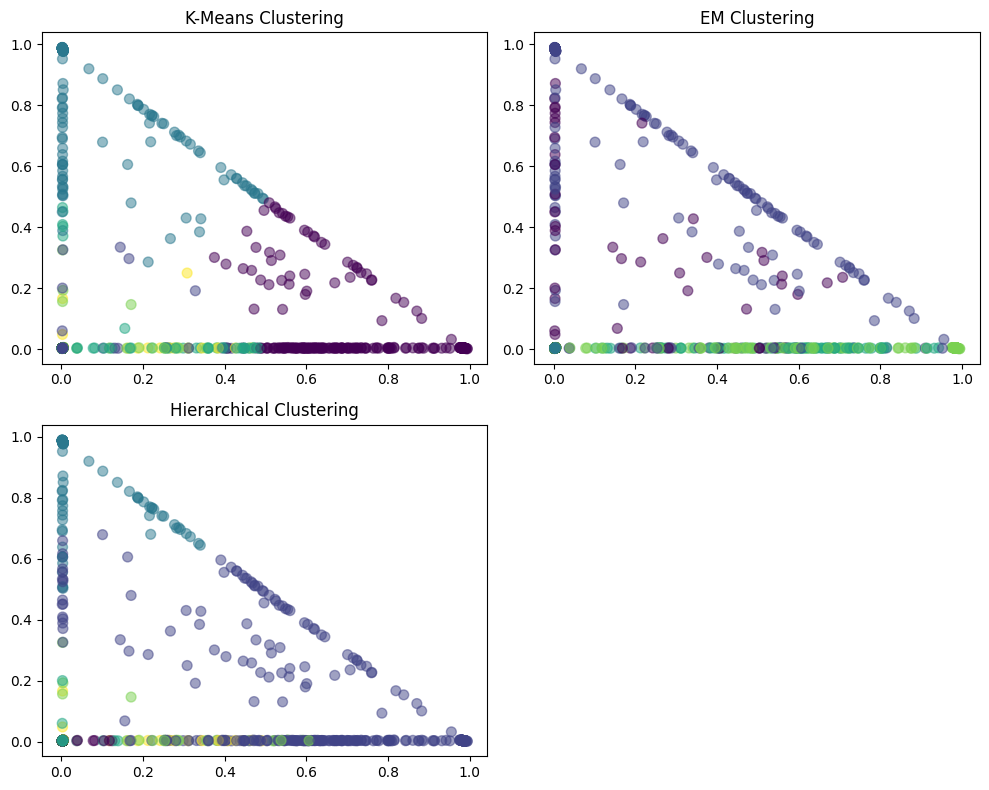

In [ ]:
import matplotlib.pyplot as plt

# Visualize clusters using scatter plot
plt.figure(figsize=(10, 8))

# Plot K-Means clusters
plt.subplot(2, 2, 1)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c= df['k-means cluster'], cmap='viridis', s=50, alpha=0.5)
plt.title('K-Means Clustering')

# Plot EM clusters
plt.subplot(2, 2, 2)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=df['gmm_clusters'], cmap='viridis', s=50, alpha=0.5)
plt.title('EM Clustering')

# Plot Hierarchical clustering
plt.subplot(2, 2, 3)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=df['Hierarchical_Clusters'], cmap='viridis', s=50, alpha=0.5)
plt.title('Hierarchical Clustering')

plt.tight_layout()
plt.show()